# Setup

In [1]:
import pandas as pd
import datetime
import time
import logging
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import sqlite3
import multiprocessing
from gensim.models import Word2Vec

In [2]:
multiprocessing.cpu_count()

8

In [32]:
PATH = 'data'
PATH1 = 'models'
PATH2 = 'models_vecsize'


MOVIELENS_1M = os.path.join(PATH, 'movielens_1m.csv')
MODEL = os.path.join(PATH1, 'w10ng11_model.model')
BEST_MODEL = 'models_vecsize/64w9_model.model'

# Data

In [4]:
dataset = pd.read_csv(MOVIELENS_1M)
print(dataset.shape)
dataset.head()

(1000209, 4)


,user_id,movie_id,rating,timestamp
0,6040,858,4,956703932
1,6040,2384,4,956703954
2,6040,593,5,956703954
3,6040,1961,4,956703977
4,6040,2019,5,956703977


# Pre-processing

In [5]:
# dataset['timestamp'] = dataset['timestamp'].apply(lambda s: datetime.datetime.strptime(s, '%Y-%m-%d %H:%M:%S+00:00'))
dataset.sort_values('timestamp', ascending=True, inplace=True)
dataset

,user_id,movie_id,rating,timestamp
0,6040,858,4,956703932
1,6040,2384,4,956703954
2,6040,593,5,956703954
3,6040,1961,4,956703977
4,6040,2019,5,956703977
...,...,...,...,...
1000204,4958,2399,1,1046454338
1000205,4958,1407,5,1046454443
1000207,4958,2634,3,1046454548
1000206,4958,3264,4,1046454548


## Visualize

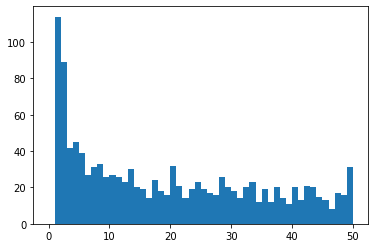

In [6]:
_ = plt.hist(dataset["movie_id"].value_counts().values, bins=50, range=(0, 50))

## Set sessions

In [7]:
start = time.time()
sessions = []
for user_id, df in dataset.groupby('user_id', sort=False):
    session = []
    for index, row in df.iterrows():
        session.append(str(row['movie_id']))
  
    sessions.append(session)
    
print("Took {}'s".format(time.time() - start))

print(sessions[0])

Took 74.16014909744263's
['858', '2384', '593', '1961', '2019', '1419', '213', '3111', '573', '3505', '1734', '919', '912', '2503', '527', '1252', '649', '318', '3289', '759', '2858', '608', '2396', '1649', '2028', '326', '2762', '34', '17', '246', '2692', '1617', '300', '1392', '1111', '150', '562', '549', '1537', '448', '866', '1554', '265', '2324', '1358', '235', '247', '446', '1704', '1094', '50', '45', '162', '348', '508', '589', '1089', '58', '2580', '1694', '1834', '2391', '290', '1641', '357', '1225', '1299', '1189', '2020', '541', '1293', '1296', '3067', '3543', '3094', '1217', '2512', '2859', '1231', '1259', '1240', '3424', '1300', '2349', '1036', '3361', '1198', '1199', '1196', '1242', '1288', '3068', '1307', '1394', '1090', '1097', '1185', '1975', '1150', '2791', '1962', '3521', '1200', '1960', '3072', '3039', '1285', '1096', '1079', '2348', '2070', '2076', '2312', '1374', '2987', '3070', '1210', '2716', '1376', '2872', '1246', '2150', '3422', '2455', '2750', '1965', '3101'

## Describe

In [8]:
n_ratings = dataset.shape[0]
n_movies = len(dataset['movie_id'].unique())
n_sessions = len(sessions)

print('Number of ratings: {}'.format(n_ratings))
print('Number of movies: {}'.format(n_movies))
print('Number of users/sessions: {}'.format(n_sessions))

Number of ratings: 1000209
Number of movies: 3706
Number of users/sessions: 6040


In [9]:
def make_gsessions(sessions, l=5):
    gsessions = []
    for session in sessions:
        if len(session) >= l:
            gsessions.append(session)
    return gsessions

gen_sessions = make_gsessions(sessions, l=20)
print('{} sessions > 20'.format(len(gen_sessions)))

6040 sessions > 20


## Filtering

In [10]:
def get_count(tp, id):
    playcount_groupbyid = tp[[id]].groupby(id)
    count = playcount_groupbyid.size()
    return count


def filter_triplets(tp, min_uc=5, min_sc=0):
    # Only keep the triplets for items which were clicked on by at least min_sc users. 
    if min_sc > 0:
        itemcount = get_count(tp, 'movie_id')
        tp = tp[tp['movie_id'].isin(itemcount.index[itemcount >= min_sc])]
    
    # Only keep the triplets for users who clicked on at least min_uc items
    # After doing this, some of the items will have less than min_uc users, but should only be a small proportion
    if min_uc > 0:
        usercount = get_count(tp, 'user_id')
        tp = tp[tp['user_id'].isin(usercount.index[usercount >= min_uc])]
    
    # Update both usercount and itemcount after filtering
    usercount, itemcount = get_count(tp, 'user_id'), get_count(tp, 'movie_id')
    return tp, usercount, itemcount


raw_data, user_activity, item_popularity = filter_triplets(df)
sparsity = 1. * raw_data.shape[0] / (user_activity.shape[0] * item_popularity.shape[0])

print("After filtering, there are %d watching events from %d users and %d movies (sparsity: %.3f%%)" % 
      (raw_data.shape[0], user_activity.shape[0], item_popularity.shape[0], sparsity * 100))

After filtering, there are 136 watching events from 1 users and 136 movies (sparsity: 100.000%)


# Training the Model

In [11]:
logging.basicConfig(format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', level=logging.INFO)
logging.root.level = logging.INFO

In [12]:
model = Word2Vec(
    gen_sessions,
    size=32,            # Vector dimensions
    window=10,          # Sliding window size
    sg=1,               # Use the skip gram model
    hs=0,               # Use negative sampling
    negative=10,        # Number of negative samples
    ns_exponent=-0.5,   # Unigram distribution's exponent
    sample=1e-4,        # Subsampling rate
    workers=(2 * multiprocessing.cpu_count() + 1),
    iter=10
)
model.save("movie_session.model") 

2021-01-10 09:48:19,477 - gensim.models.word2vec - INFO - collecting all words and their counts
2021-01-10 09:48:19,478 - gensim.models.word2vec - INFO - PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-01-10 09:48:19,696 - gensim.models.word2vec - INFO - collected 3706 word types from a corpus of 1000209 raw words and 6040 sentences
2021-01-10 09:48:19,696 - gensim.models.word2vec - INFO - Loading a fresh vocabulary
2021-01-10 09:48:19,742 - gensim.models.word2vec - INFO - effective_min_count=5 retains 3416 unique words (92% of original 3706, drops 290)
2021-01-10 09:48:19,744 - gensim.models.word2vec - INFO - effective_min_count=5 leaves 999611 word corpus (99% of original 1000209, drops 598)
2021-01-10 09:48:19,774 - gensim.models.word2vec - INFO - deleting the raw counts dictionary of 3706 items
2021-01-10 09:48:19,775 - gensim.models.word2vec - INFO - sample=0.0001 downsamples 1183 most-common words
2021-01-10 09:48:19,776 - gensim.models.word2vec - INFO - do

In [13]:
models = [Word2Vec(
    gen_sessions,
    size=32,            # Vector dimensions
    window=i,           # Sliding window size
    sg=1,               # Use the skip gram model
    hs=0,               # Use negative sampling
    negative=j,        # Number of negative samples
    ns_exponent=-0.5,   # Unigram distribution's exponent
    sample=1e-4,        # Subsampling rate
    workers=(2 * multiprocessing.cpu_count() + 1),
    iter=10
) for i in range(5,11) for j in range(20,10,-1)]

2021-01-10 09:48:42,710 - gensim.models.word2vec - INFO - collecting all words and their counts
2021-01-10 09:48:42,711 - gensim.models.word2vec - INFO - PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-01-10 09:48:42,803 - gensim.models.word2vec - INFO - collected 3706 word types from a corpus of 1000209 raw words and 6040 sentences
2021-01-10 09:48:42,803 - gensim.models.word2vec - INFO - Loading a fresh vocabulary
2021-01-10 09:48:42,810 - gensim.models.word2vec - INFO - effective_min_count=5 retains 3416 unique words (92% of original 3706, drops 290)
2021-01-10 09:48:42,810 - gensim.models.word2vec - INFO - effective_min_count=5 leaves 999611 word corpus (99% of original 1000209, drops 598)
2021-01-10 09:48:42,820 - gensim.models.word2vec - INFO - deleting the raw counts dictionary of 3706 items
2021-01-10 09:48:42,820 - gensim.models.word2vec - INFO - sample=0.0001 downsamples 1183 most-common words
2021-01-10 09:48:42,821 - gensim.models.word2vec - INFO - do

In [14]:
len(models)

60

In [16]:
ids = ["w" + str(i) + "ng" + str(j) for i in range(5,11) for j in range(20,10,-1)]
for i, ele in enumerate(models):
  ele.save(os.path.join(PATH1,ids[i]+"_model.model"))

2021-01-10 10:29:05,984 - gensim.utils - INFO - saving Word2Vec object under models/w5ng20_model.model, separately None
2021-01-10 10:29:05,985 - gensim.utils - INFO - not storing attribute vectors_norm
2021-01-10 10:29:05,986 - gensim.utils - INFO - not storing attribute cum_table
2021-01-10 10:29:06,000 - gensim.utils - INFO - saved models/w5ng20_model.model
2021-01-10 10:29:06,001 - gensim.utils - INFO - saving Word2Vec object under models/w5ng19_model.model, separately None
2021-01-10 10:29:06,001 - gensim.utils - INFO - not storing attribute vectors_norm
2021-01-10 10:29:06,002 - gensim.utils - INFO - not storing attribute cum_table
2021-01-10 10:29:06,016 - gensim.utils - INFO - saved models/w5ng19_model.model
2021-01-10 10:29:06,016 - gensim.utils - INFO - saving Word2Vec object under models/w5ng18_model.model, separately None
2021-01-10 10:29:06,017 - gensim.utils - INFO - not storing attribute vectors_norm
2021-01-10 10:29:06,018 - gensim.utils - INFO - not storing attribute c

## Loading the Model

In [17]:
w10ng11_model = Word2Vec.load(MODEL)

2021-01-10 10:29:16,304 - gensim.utils - INFO - loading Word2Vec object from models/w10ng11_model.model
2021-01-10 10:29:16,320 - gensim.utils - INFO - loading wv recursively from models/w10ng11_model.model.wv.* with mmap=None
2021-01-10 10:29:16,321 - gensim.utils - INFO - setting ignored attribute vectors_norm to None
2021-01-10 10:29:16,322 - gensim.utils - INFO - loading vocabulary recursively from models/w10ng11_model.model.vocabulary.* with mmap=None
2021-01-10 10:29:16,322 - gensim.utils - INFO - loading trainables recursively from models/w10ng11_model.model.trainables.* with mmap=None
2021-01-10 10:29:16,323 - gensim.utils - INFO - setting ignored attribute cum_table to None
2021-01-10 10:29:16,323 - gensim.utils - INFO - loaded models/w10ng11_model.model


In [18]:
w10ng11_model.wv.most_similar(['3071'])

2021-01-10 10:29:18,269 - gensim.models.keyedvectors - INFO - precomputing L2-norms of word weight vectors


[('1962', 0.9631903171539307),
 ('3098', 0.9616153836250305),
 ('1302', 0.9548141956329346),
 ('2739', 0.9510174989700317),
 ('2929', 0.9507926106452942),
 ('3111', 0.9473909139633179),
 ('2312', 0.941814661026001),
 ('1246', 0.9396936893463135),
 ('3169', 0.9379265308380127),
 ('2852', 0.9377927184104919)]

In [19]:
w10ng11_model.wv.vocab

{'858': <gensim.models.keyedvectors.Vocab at 0x7fe03d264550>,
 '2384': <gensim.models.keyedvectors.Vocab at 0x7fe03d2bf470>,
 '593': <gensim.models.keyedvectors.Vocab at 0x7fe03daf1f98>,
 '1961': <gensim.models.keyedvectors.Vocab at 0x7fe026e79fd0>,
 '2019': <gensim.models.keyedvectors.Vocab at 0x7fe026e792e8>,
 '1419': <gensim.models.keyedvectors.Vocab at 0x7fe026e790b8>,
 '213': <gensim.models.keyedvectors.Vocab at 0x7fe026e79278>,
 '3111': <gensim.models.keyedvectors.Vocab at 0x7fe026e79240>,
 '573': <gensim.models.keyedvectors.Vocab at 0x7fe026e79198>,
 '3505': <gensim.models.keyedvectors.Vocab at 0x7fe026e79358>,
 '1734': <gensim.models.keyedvectors.Vocab at 0x7fe026e793c8>,
 '919': <gensim.models.keyedvectors.Vocab at 0x7fe026e79470>,
 '912': <gensim.models.keyedvectors.Vocab at 0x7fe026e794e0>,
 '2503': <gensim.models.keyedvectors.Vocab at 0x7fe026e79550>,
 '527': <gensim.models.keyedvectors.Vocab at 0x7fe026e795c0>,
 '1252': <gensim.models.keyedvectors.Vocab at 0x7fe026e79630>,

# Exploring the Model

## Most similar to

In [20]:
print(gen_sessions[1][:5])
print(gen_sessions[1][:])

['111', '282', '2067', '1230', '930']
['111', '282', '2067', '1230', '930', '947', '3088', '3022', '3133', '1294', '2804', '3421', '1269', '1244', '955', '1276', '2622', '2791', '2300', '1028', '2396', '1197', '2863', '3548', '1211', '1223', '951', '933', '3072', '1066', '907', '935', '1304', '2671', '3175', '3363', '1014', '1078', '3035', '1270', '1265', '909', '3396', '911', '1934', '2174', '945', '2746', '952', '3037', '1188', '471', '2289', '916', '1125', '915', '1641', '3028', '750', '260', '3471', '1097', '924', '1210', '3545', '2087', '914', '919', '2565', '900', '899', '918', '1282', '1022', '3549', '364', '963', '1947', '588', '1951', '1380', '2857', '107', '1220', '2946', '1081', '2083', '938', '2096', '661', '1088', '901', '783', '2080', '1083', '1416', '199', '48', '1284', '904', '913', '903', '1212', '1086', '1964', '2206', '950', '2208', '906', '942', '2414', '1680', '926', '1237', '1252', '2019', '923', '858', '1148', '1204', '922', '912', '1254']


In [21]:
session_train = gen_sessions[1][:5]
session_test = gen_sessions[1][5:10]

In [22]:
def suggested():
    res = model.wv.most_similar(positive=session_test,
                          negative=[],
                          topn = 5)
    sug_list = []
    for _ in range(len(res)):
        sug_list.append(res[_][0])
    return sug_list

In [23]:
suggested()

2021-01-10 10:29:31,184 - gensim.models.keyedvectors - INFO - precomputing L2-norms of word weight vectors


['905', '1256', '3462', '955', '951']

## Similarities

In [24]:
# model.wv.similarity('858', '598')

# Evaluate

## NDCG

In [25]:
tru = [1, 1, 1, 1, 1]
sug = [0, 0, 1, 1, 1]

def dcg_cus(tru, sug):
    n = len(sug)
    dcg = 0
    for _ in range(n):
        tmp = sug[_] / math.log((_ + 2), 2)
        dcg = dcg + tmp
    return dcg

def idcg_cus(tru, sug):
    return dcg_cus(tru, tru)

def ndcg_cus(tru, sug):
    return dcg_cus(tru, sug) / idcg_cus(tru, sug)

dcg = dcg_cus(tru, sug)
idcg = idcg_cus(tru, sug)
ndcg = ndcg_cus(tru, sug)

print(" DCG score:", dcg)
print("IDCG score:", idcg)
print("nDCG score:", ndcg)

 DCG score: 1.3175293653079347
IDCG score: 2.948459118879392
nDCG score: 0.4468535299918564


In [26]:
rec = [3, 2, 1, 4, 5]
ideal = [4, 5, 6, 1, 10]

def comp(x,y):
  re = []
  sug = [int(ele in y) for ele in x]
  tru = [1 for ele in x]
  #dcg = dcg_cus(tru, sug)
  #idcg = idcg_cus(tru, sug)
  ndcg = ndcg_cus(tru, sug)
  return ndcg

comp(rec,ideal)   

0.4468535299918564

In [27]:
def evaluate_with_model_ndcg(model_option,n_in=5, n_out=10, topn=15):
  sess = make_gsessions(sessions, n_in+n_out)
  #print('Number of sessions: {}'.format(len(sess)))

  start_in = - n_out - n_in
  end_in = - n_out
  inp = [sess[i][start_in:end_in] for i in range(len(sess))]
  test = [sess[i][end_in:] for i in range(len(sess))]
  out = []
  for ele in inp:
    try:
      out.append([ele1[0] for ele1 in model_option.wv.most_similar(ele, topn=topn)])
    except:
      out.append(None)

  s = 0
  n = len(out)
  for i in range(n):
    if out[i] != None:
      s += comp(out[i],test[i])
  return s/n

evaluate_with_model_ndcg(models[0])  

2021-01-10 10:29:35,441 - gensim.models.keyedvectors - INFO - precomputing L2-norms of word weight vectors


0.07790093726022213

In [45]:
# best_model = Word2Vec.load(BEST_MODEL)
# score_ndcg = evaluate_with_model_ndcg(best_model)

In [46]:
# score_ndcg

## Hit Rate

In [33]:
sessions_10 = make_gsessions(sessions, 10)
len(sessions_10)

6040

In [34]:
pred = model.wv.most_similar(sessions_10[0][-10:-5])
sug_list = []
for v, sim in pred:
    sug_list.append(v)
    
sug_list

['778', '1095', '1635', '1885', '1060', '3060', '235', '428', '1245', '337']

In [35]:
valid = sessions_10[0][:]
test = sessions_10[0][-5:]
inp = sessions_10[0][-10:-5]
out = sug_list

print('Train:', valid)
print('Test:', test)
print('Input:', inp)
print('Output:', out)

Train: ['858', '2384', '593', '1961', '2019', '1419', '213', '3111', '573', '3505', '1734', '919', '912', '2503', '527', '1252', '649', '318', '3289', '759', '2858', '608', '2396', '1649', '2028', '326', '2762', '34', '17', '246', '2692', '1617', '300', '1392', '1111', '150', '562', '549', '1537', '448', '866', '1554', '265', '2324', '1358', '235', '247', '446', '1704', '1094', '50', '45', '162', '348', '508', '589', '1089', '58', '2580', '1694', '1834', '2391', '290', '1641', '357', '1225', '1299', '1189', '2020', '541', '1293', '1296', '3067', '3543', '3094', '1217', '2512', '2859', '1231', '1259', '1240', '3424', '1300', '2349', '1036', '3361', '1198', '1199', '1196', '1242', '1288', '3068', '1307', '1394', '1090', '1097', '1185', '1975', '1150', '2791', '1962', '3521', '1200', '1960', '3072', '3039', '1285', '1096', '1079', '2348', '2070', '2076', '2312', '1374', '2987', '3070', '1210', '2716', '1376', '2872', '1246', '2150', '3422', '2455', '2750', '1965', '3101', '1321', '1305', 

In [36]:
def hit_rate_m(output,test):
    for ele in output:
        if ele in test:
            return 1
    return 0

hit_rate_m(out, test)

0

In [37]:
def test_hit_rate(inputs, tests, topn=50):
    n = len(inputs)
    m = len(tests)
    if n != m:
        return None
    s = 0
    for i in range(n):
        try:
            out = [ele[0] for ele in model.wv.most_similar(inputs[i], topn=topn)]
            s += hit_rate_m(out,tests[i])
        except:
            m -= 1
    return s/m

test = [sessions_10[i][-5:] for i in range(len(sessions_10))]
inp = [sessions_10[i][-10:-5] for i in range(len(sessions_10))]

HR_scores = test_hit_rate(inp, test)

print('Hit rate: {}'.format(HR_scores))

Hit rate: 0.6939690978567868


### Print SCORE

In [38]:
def print_hit_rate(inp, test, topn=5):
  n = []
  m = []
  for i in range(topn):
    c = i+1
    n.append(c*10)
    m.append(test_hit_rate(inp, test, topn=c*10))
    print('Hit rate @{}0: {}'.format(c, test_hit_rate(inp, test, topn=c*10)))
  return pd.DataFrame(dict({"hit-rate":m}),index = [str((i+1)*10) for i in range(topn)])
print_hit_rate(inp, test, 10)

Hit rate @10: 0.37564379465027414
Hit rate @20: 0.5145372985545772
Hit rate @30: 0.5976075760093039
Hit rate @40: 0.6502741319156006
Hit rate @50: 0.6939690978567868
Hit rate @60: 0.7262003655092208
Hit rate @70: 0.7487954809769065
Hit rate @80: 0.7695630503405881
Hit rate @90: 0.7856786841668051
Hit rate @100: 0.8001329124439276


,hit-rate
10,0.375644
20,0.514537
30,0.597608
40,0.650274
50,0.693969
60,0.726200
70,0.748795
80,0.769563
90,0.785679
100,0.800133


### Evaluate function

In [39]:
def evaluate(n_in=5, n_out=5):
  sess = make_gsessions(sessions, n_in+n_out)
  print('Number of sessions: {}'.format(len(sess)))

  start_in = - n_out - n_in
  end_in = - n_out
  inp = [sess[i][start_in:end_in] for i in range(len(sess))]
  test = [sess[i][end_in:] for i in range(len(sess))]

  return print_hit_rate(inp, test, 10)

In [40]:
evaluate(5, 5)

Number of sessions: 6040
Hit rate @10: 0.37564379465027414
Hit rate @20: 0.5145372985545772
Hit rate @30: 0.5976075760093039
Hit rate @40: 0.6502741319156006
Hit rate @50: 0.6939690978567868
Hit rate @60: 0.7262003655092208
Hit rate @70: 0.7487954809769065
Hit rate @80: 0.7695630503405881
Hit rate @90: 0.7856786841668051
Hit rate @100: 0.8001329124439276


,hit-rate
10,0.375644
20,0.514537
30,0.597608
40,0.650274
50,0.693969
60,0.726200
70,0.748795
80,0.769563
90,0.785679
100,0.800133


### Tuning parameters

In [41]:
dframes = [evaluate(i*5, j*5) for i in range(1,4) for j in range(1,3)]

Number of sessions: 6040
Hit rate @10: 0.37564379465027414
Hit rate @20: 0.5145372985545772
Hit rate @30: 0.5976075760093039
Hit rate @40: 0.6502741319156006
Hit rate @50: 0.6939690978567868
Hit rate @60: 0.7262003655092208
Hit rate @70: 0.7487954809769065
Hit rate @80: 0.7695630503405881
Hit rate @90: 0.7856786841668051
Hit rate @100: 0.8001329124439276
Number of sessions: 6040
Hit rate @10: 0.488298755186722
Hit rate @20: 0.6262240663900415
Hit rate @30: 0.7093775933609958
Hit rate @40: 0.7643153526970954
Hit rate @50: 0.797344398340249
Hit rate @60: 0.820746887966805
Hit rate @70: 0.8371784232365145
Hit rate @80: 0.8517842323651452
Hit rate @90: 0.864896265560166
Hit rate @100: 0.8755186721991701
Number of sessions: 6040
Hit rate @10: 0.3271183619111037
Hit rate @20: 0.4649575495255535
Hit rate @30: 0.5500249708673215
Hit rate @40: 0.6114533044781089
Hit rate @50: 0.652072581987681
Hit rate @60: 0.6878641584817713
Hit rate @70: 0.7164974196770435
Hit rate @80: 0.7379723655734975
Hit

In [42]:
comparison_matrix = pd.concat(dframes,axis = 1)

In [43]:
comparison_matrix = pd.DataFrame(comparison_matrix.to_numpy(),index = [str(i*10) for i in range(1,11)],columns = ["in:" + str(i*5)+",out:" + str(j*5) for i in range(1,4) for j in range(1,3)])

<AxesSubplot:>

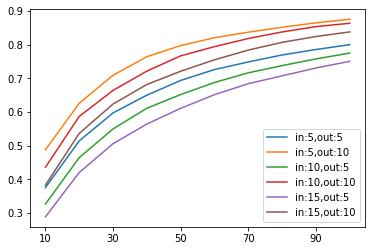

In [44]:
comparison_matrix.plot()

###Choosing hyperparam

##### Function

In [47]:
def plot_eval(dfs,names):
  comparison_matrix = pd.concat(dfs,axis = 1)
  comparison_matrix = pd.DataFrame(comparison_matrix.to_numpy(),index = [str(i*10) for i in range(1,11)],columns = names)
  comparison_matrix.plot()

In [48]:
def hitrate_with_model(model_option,inputs, tests, topn=50):
    n = len(inputs)
    m = len(tests)
    if n != m:
        return None
    s = 0
    for i in range(n):
        try:
            out = [ele[0] for ele in model_option.wv.most_similar(inputs[i], topn=topn)]
            s += hit_rate_m(out,tests[i])
        except:
            m -= 1
    return s/m

In [49]:
def print_hitrate_with_model(model_option,inp, test, topn=5):
  n = []
  m = []
  for i in range(topn):
    c = i+1
    n.append(c*10)
    m.append(hitrate_with_model(model_option,inp, test, topn=c*10))
    #print('Hit rate @{}0: {}'.format(c, test_hit_rate(model_option,inp, test, topn=c*10)))
  return pd.DataFrame(dict({"hit-rate":m}),index = [str((i+1)*10) for i in range(topn)])

In [50]:
def evaluate_with_model(model_option,n_in=5, n_out=5):
  sess = make_gsessions(sessions, n_in+n_out)
  #print('Number of sessions: {}'.format(len(sess)))

  start_in = - n_out - n_in
  end_in = - n_out
  inp = [sess[i][start_in:end_in] for i in range(len(sess))]
  test = [sess[i][end_in:] for i in range(len(sess))]

  return print_hitrate_with_model(model_option,inp, test, 10)

#### Window size & Negative sampling

2021-01-10 10:38:09,205 - gensim.utils - INFO - loading Word2Vec object from models/w5ng20_model.model
2021-01-10 10:38:09,216 - gensim.utils - INFO - loading wv recursively from models/w5ng20_model.model.wv.* with mmap=None
2021-01-10 10:38:09,217 - gensim.utils - INFO - setting ignored attribute vectors_norm to None
2021-01-10 10:38:09,217 - gensim.utils - INFO - loading vocabulary recursively from models/w5ng20_model.model.vocabulary.* with mmap=None
2021-01-10 10:38:09,218 - gensim.utils - INFO - loading trainables recursively from models/w5ng20_model.model.trainables.* with mmap=None
2021-01-10 10:38:09,218 - gensim.utils - INFO - setting ignored attribute cum_table to None
2021-01-10 10:38:09,219 - gensim.utils - INFO - loaded models/w5ng20_model.model
2021-01-10 10:38:09,232 - gensim.models.keyedvectors - INFO - precomputing L2-norms of word weight vectors
2021-01-10 10:38:20,023 - gensim.utils - INFO - loading Word2Vec object from models/w5ng19_model.model
2021-01-10 10:38:20,1

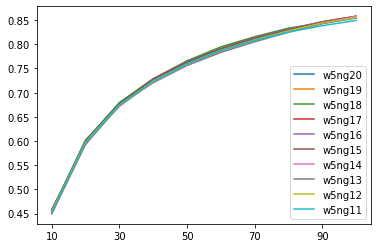

In [58]:
df_5x = []
names = []
for i in range(20,10,-1):
    name = "w5ng"+str(i)
    cur_5x = Word2Vec.load(os.path.join(PATH1,name+"_model.model"))
    names.append(name)
    df_5x.append(evaluate_with_model(cur_5x,5,10))
plot_eval(df_5x,names)

2021-01-10 10:39:58,695 - gensim.utils - INFO - loading Word2Vec object from models/w6ng20_model.model
2021-01-10 10:39:58,831 - gensim.utils - INFO - loading wv recursively from models/w6ng20_model.model.wv.* with mmap=None
2021-01-10 10:39:58,832 - gensim.utils - INFO - setting ignored attribute vectors_norm to None
2021-01-10 10:39:58,832 - gensim.utils - INFO - loading vocabulary recursively from models/w6ng20_model.model.vocabulary.* with mmap=None
2021-01-10 10:39:58,833 - gensim.utils - INFO - loading trainables recursively from models/w6ng20_model.model.trainables.* with mmap=None
2021-01-10 10:39:58,834 - gensim.utils - INFO - setting ignored attribute cum_table to None
2021-01-10 10:39:58,834 - gensim.utils - INFO - loaded models/w6ng20_model.model
2021-01-10 10:39:58,849 - gensim.models.keyedvectors - INFO - precomputing L2-norms of word weight vectors
2021-01-10 10:40:10,311 - gensim.utils - INFO - loading Word2Vec object from models/w6ng19_model.model
2021-01-10 10:40:10,3

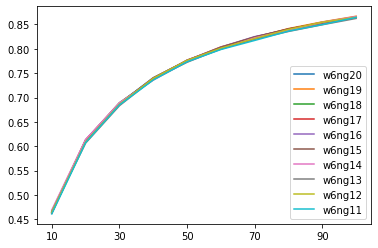

In [59]:
df_6x = []
names = []
for i in range(20,10,-1):
    name = "w6ng"+str(i)
    cur_6x = Word2Vec.load(os.path.join(PATH1,name+"_model.model"))
    names.append(name)
    df_6x.append(evaluate_with_model(cur_6x,5,10))
plot_eval(df_6x,names)

2021-01-10 10:41:50,618 - gensim.utils - INFO - loading Word2Vec object from models/w7ng20_model.model
2021-01-10 10:41:50,636 - gensim.utils - INFO - loading wv recursively from models/w7ng20_model.model.wv.* with mmap=None
2021-01-10 10:41:50,637 - gensim.utils - INFO - setting ignored attribute vectors_norm to None
2021-01-10 10:41:50,638 - gensim.utils - INFO - loading vocabulary recursively from models/w7ng20_model.model.vocabulary.* with mmap=None
2021-01-10 10:41:50,638 - gensim.utils - INFO - loading trainables recursively from models/w7ng20_model.model.trainables.* with mmap=None
2021-01-10 10:41:50,639 - gensim.utils - INFO - setting ignored attribute cum_table to None
2021-01-10 10:41:50,640 - gensim.utils - INFO - loaded models/w7ng20_model.model
2021-01-10 10:41:50,667 - gensim.models.keyedvectors - INFO - precomputing L2-norms of word weight vectors
2021-01-10 10:42:04,503 - gensim.utils - INFO - loading Word2Vec object from models/w7ng19_model.model
2021-01-10 10:42:04,5

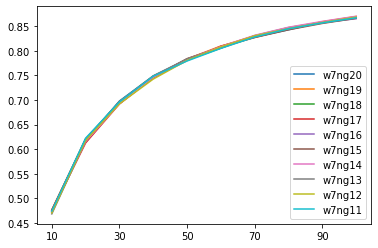

In [60]:
df_7x = []
names = []
for i in range(20,10,-1):
    name = "w7ng"+str(i)
    cur_7x = Word2Vec.load(os.path.join(PATH1,name+"_model.model"))
    names.append(name)
    df_7x.append(evaluate_with_model(cur_7x,5,10))
plot_eval(df_7x,names)

2021-01-10 10:47:17,570 - gensim.utils - INFO - loading Word2Vec object from models/w8ng20_model.model
2021-01-10 10:47:17,589 - gensim.utils - INFO - loading wv recursively from models/w8ng20_model.model.wv.* with mmap=None
2021-01-10 10:47:17,590 - gensim.utils - INFO - setting ignored attribute vectors_norm to None
2021-01-10 10:47:17,590 - gensim.utils - INFO - loading vocabulary recursively from models/w8ng20_model.model.vocabulary.* with mmap=None
2021-01-10 10:47:17,591 - gensim.utils - INFO - loading trainables recursively from models/w8ng20_model.model.trainables.* with mmap=None
2021-01-10 10:47:17,591 - gensim.utils - INFO - setting ignored attribute cum_table to None
2021-01-10 10:47:17,591 - gensim.utils - INFO - loaded models/w8ng20_model.model
2021-01-10 10:47:17,612 - gensim.models.keyedvectors - INFO - precomputing L2-norms of word weight vectors
2021-01-10 10:47:29,279 - gensim.utils - INFO - loading Word2Vec object from models/w8ng19_model.model
2021-01-10 10:47:29,2

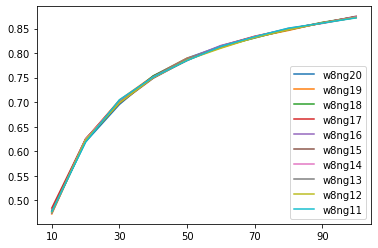

In [62]:
df_8x = []
names = []
for i in range(20,10,-1):
    name = "w8ng"+str(i)
    cur_8x = Word2Vec.load(os.path.join(PATH1,name+"_model.model"))
    names.append(name)
    df_8x.append(evaluate_with_model(cur_8x,5,10))
plot_eval(df_8x,names)

2021-01-10 10:49:07,346 - gensim.utils - INFO - loading Word2Vec object from models/w9ng20_model.model
2021-01-10 10:49:07,356 - gensim.utils - INFO - loading wv recursively from models/w9ng20_model.model.wv.* with mmap=None
2021-01-10 10:49:07,357 - gensim.utils - INFO - setting ignored attribute vectors_norm to None
2021-01-10 10:49:07,358 - gensim.utils - INFO - loading vocabulary recursively from models/w9ng20_model.model.vocabulary.* with mmap=None
2021-01-10 10:49:07,358 - gensim.utils - INFO - loading trainables recursively from models/w9ng20_model.model.trainables.* with mmap=None
2021-01-10 10:49:07,359 - gensim.utils - INFO - setting ignored attribute cum_table to None
2021-01-10 10:49:07,359 - gensim.utils - INFO - loaded models/w9ng20_model.model
2021-01-10 10:49:07,373 - gensim.models.keyedvectors - INFO - precomputing L2-norms of word weight vectors
2021-01-10 10:49:16,892 - gensim.utils - INFO - loading Word2Vec object from models/w9ng19_model.model
2021-01-10 10:49:16,9

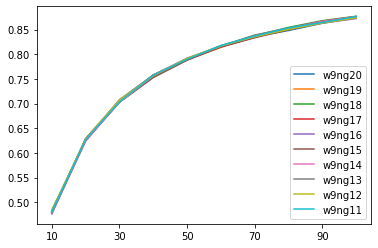

In [63]:
df_9x = []
names = []
for i in range(20,10,-1):
    name = "w9ng"+str(i)
    cur_9x = Word2Vec.load(os.path.join(PATH1,name+"_model.model"))
    names.append(name)
    df_9x.append(evaluate_with_model(cur_9x,5,10))
plot_eval(df_9x,names)

2021-01-10 10:50:48,381 - gensim.utils - INFO - loading Word2Vec object from models/w10ng20_model.model
2021-01-10 10:50:48,392 - gensim.utils - INFO - loading wv recursively from models/w10ng20_model.model.wv.* with mmap=None
2021-01-10 10:50:48,393 - gensim.utils - INFO - setting ignored attribute vectors_norm to None
2021-01-10 10:50:48,393 - gensim.utils - INFO - loading vocabulary recursively from models/w10ng20_model.model.vocabulary.* with mmap=None
2021-01-10 10:50:48,394 - gensim.utils - INFO - loading trainables recursively from models/w10ng20_model.model.trainables.* with mmap=None
2021-01-10 10:50:48,394 - gensim.utils - INFO - setting ignored attribute cum_table to None
2021-01-10 10:50:48,394 - gensim.utils - INFO - loaded models/w10ng20_model.model
2021-01-10 10:50:48,417 - gensim.models.keyedvectors - INFO - precomputing L2-norms of word weight vectors
2021-01-10 10:50:59,146 - gensim.utils - INFO - loading Word2Vec object from models/w10ng19_model.model
2021-01-10 10:5

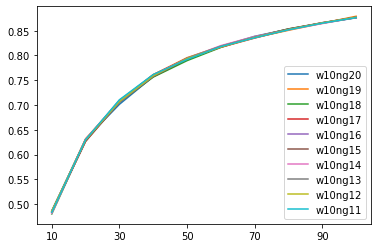

In [64]:
df_10x = []
names = []
for i in range(20,10,-1):
    name = "w10ng"+str(i)
    cur_10x = Word2Vec.load(os.path.join(PATH1,name+"_model.model"))
    names.append(name)
    df_10x.append(evaluate_with_model(cur_10x,5,10))
plot_eval(df_10x,names)

2021-01-10 10:52:39,985 - gensim.utils - INFO - loading Word2Vec object from models/w5ng20_model.model
2021-01-10 10:52:39,998 - gensim.utils - INFO - loading wv recursively from models/w5ng20_model.model.wv.* with mmap=None
2021-01-10 10:52:39,999 - gensim.utils - INFO - setting ignored attribute vectors_norm to None
2021-01-10 10:52:40,000 - gensim.utils - INFO - loading vocabulary recursively from models/w5ng20_model.model.vocabulary.* with mmap=None
2021-01-10 10:52:40,000 - gensim.utils - INFO - loading trainables recursively from models/w5ng20_model.model.trainables.* with mmap=None
2021-01-10 10:52:40,001 - gensim.utils - INFO - setting ignored attribute cum_table to None
2021-01-10 10:52:40,001 - gensim.utils - INFO - loaded models/w5ng20_model.model
2021-01-10 10:52:40,026 - gensim.models.keyedvectors - INFO - precomputing L2-norms of word weight vectors
2021-01-10 10:52:50,000 - gensim.utils - INFO - loading Word2Vec object from models/w6ng20_model.model
2021-01-10 10:52:50,0

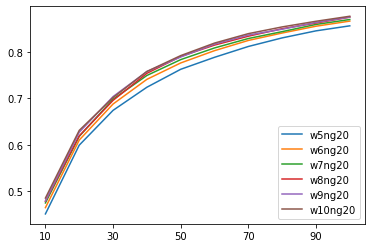

In [66]:
names_eval = ["w" + str(i)+"ng20" for i in range(5,11)]
dfs_eval = []
for i in range(6):
    tmp = Word2Vec.load(os.path.join(PATH1,names_eval[i]+"_model.model"))
    dfs_eval.append(evaluate_with_model(tmp,5,10))
plot_eval(dfs_eval,names_eval)

In [67]:
print("With window size of 9, the model works at best performance")

With window size of 9, the model works at best performance


#### Vector dimensions

In [68]:
size_of_vector = [16,32,64]
models_eval_size = [Word2Vec(
    gen_sessions,
    size=ele,            # Vector dimensions
    window=9,           # Sliding window size
    sg=1,               # Use the skip gram model
    hs=0,               # Use negative sampling
    negative=18,        # Number of negative samples
    ns_exponent=-0.5,   # Unigram distribution's exponent
    sample=1e-4,        # Subsampling rate
    workers=(2 * multiprocessing.cpu_count() + 1),
    iter=10
) for ele in size_of_vector]



2021-01-10 10:53:45,150 - gensim.models.word2vec - INFO - collecting all words and their counts
2021-01-10 10:53:45,151 - gensim.models.word2vec - INFO - PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-01-10 10:53:45,294 - gensim.models.word2vec - INFO - collected 3706 word types from a corpus of 1000209 raw words and 6040 sentences
2021-01-10 10:53:45,295 - gensim.models.word2vec - INFO - Loading a fresh vocabulary
2021-01-10 10:53:45,301 - gensim.models.word2vec - INFO - effective_min_count=5 retains 3416 unique words (92% of original 3706, drops 290)
2021-01-10 10:53:45,302 - gensim.models.word2vec - INFO - effective_min_count=5 leaves 999611 word corpus (99% of original 1000209, drops 598)
2021-01-10 10:53:45,314 - gensim.models.word2vec - INFO - deleting the raw counts dictionary of 3706 items
2021-01-10 10:53:45,315 - gensim.models.word2vec - INFO - sample=0.0001 downsamples 1183 most-common words
2021-01-10 10:53:45,316 - gensim.models.word2vec - INFO - do

In [69]:
names_size_eval = []
for i,ele in enumerate(size_of_vector):
  name = str(ele)+"w9"
  names_size_eval.append(name)
  models_eval_size[i].save(os.path.join(PATH2,name +"_model.model"))

2021-01-10 10:55:32,285 - gensim.utils - INFO - saving Word2Vec object under models_vecsize/16w9_model.model, separately None
2021-01-10 10:55:32,287 - gensim.utils - INFO - not storing attribute vectors_norm
2021-01-10 10:55:32,287 - gensim.utils - INFO - not storing attribute cum_table
2021-01-10 10:55:32,301 - gensim.utils - INFO - saved models_vecsize/16w9_model.model
2021-01-10 10:55:32,302 - gensim.utils - INFO - saving Word2Vec object under models_vecsize/32w9_model.model, separately None
2021-01-10 10:55:32,303 - gensim.utils - INFO - not storing attribute vectors_norm
2021-01-10 10:55:32,303 - gensim.utils - INFO - not storing attribute cum_table
2021-01-10 10:55:32,319 - gensim.utils - INFO - saved models_vecsize/32w9_model.model
2021-01-10 10:55:32,319 - gensim.utils - INFO - saving Word2Vec object under models_vecsize/64w9_model.model, separately None
2021-01-10 10:55:32,320 - gensim.utils - INFO - not storing attribute vectors_norm
2021-01-10 10:55:32,321 - gensim.utils - 

In [70]:
dfs_vecsize_eval = []
for ele in names_size_eval:
  print(ele)
  tmp = Word2Vec.load(os.path.join(PATH2,ele +"_model.model"))
  dfs_vecsize_eval.append(evaluate_with_model(tmp,5,10))


2021-01-10 10:55:32,359 - gensim.utils - INFO - loading Word2Vec object from models_vecsize/16w9_model.model
2021-01-10 10:55:32,369 - gensim.utils - INFO - loading wv recursively from models_vecsize/16w9_model.model.wv.* with mmap=None
2021-01-10 10:55:32,370 - gensim.utils - INFO - setting ignored attribute vectors_norm to None
2021-01-10 10:55:32,370 - gensim.utils - INFO - loading vocabulary recursively from models_vecsize/16w9_model.model.vocabulary.* with mmap=None
2021-01-10 10:55:32,371 - gensim.utils - INFO - loading trainables recursively from models_vecsize/16w9_model.model.trainables.* with mmap=None
2021-01-10 10:55:32,371 - gensim.utils - INFO - setting ignored attribute cum_table to None
2021-01-10 10:55:32,372 - gensim.utils - INFO - loaded models_vecsize/16w9_model.model
2021-01-10 10:55:32,390 - gensim.models.keyedvectors - INFO - precomputing L2-norms of word weight vectors


16w9


2021-01-10 10:55:43,580 - gensim.utils - INFO - loading Word2Vec object from models_vecsize/32w9_model.model
2021-01-10 10:55:43,597 - gensim.utils - INFO - loading wv recursively from models_vecsize/32w9_model.model.wv.* with mmap=None
2021-01-10 10:55:43,600 - gensim.utils - INFO - setting ignored attribute vectors_norm to None
2021-01-10 10:55:43,602 - gensim.utils - INFO - loading vocabulary recursively from models_vecsize/32w9_model.model.vocabulary.* with mmap=None
2021-01-10 10:55:43,602 - gensim.utils - INFO - loading trainables recursively from models_vecsize/32w9_model.model.trainables.* with mmap=None
2021-01-10 10:55:43,603 - gensim.utils - INFO - setting ignored attribute cum_table to None
2021-01-10 10:55:43,604 - gensim.utils - INFO - loaded models_vecsize/32w9_model.model
2021-01-10 10:55:43,634 - gensim.models.keyedvectors - INFO - precomputing L2-norms of word weight vectors


32w9


2021-01-10 10:55:54,909 - gensim.utils - INFO - loading Word2Vec object from models_vecsize/64w9_model.model
2021-01-10 10:55:54,926 - gensim.utils - INFO - loading wv recursively from models_vecsize/64w9_model.model.wv.* with mmap=None
2021-01-10 10:55:54,927 - gensim.utils - INFO - setting ignored attribute vectors_norm to None
2021-01-10 10:55:54,928 - gensim.utils - INFO - loading vocabulary recursively from models_vecsize/64w9_model.model.vocabulary.* with mmap=None
2021-01-10 10:55:54,928 - gensim.utils - INFO - loading trainables recursively from models_vecsize/64w9_model.model.trainables.* with mmap=None
2021-01-10 10:55:54,929 - gensim.utils - INFO - setting ignored attribute cum_table to None
2021-01-10 10:55:54,929 - gensim.utils - INFO - loaded models_vecsize/64w9_model.model
2021-01-10 10:55:54,946 - gensim.models.keyedvectors - INFO - precomputing L2-norms of word weight vectors


64w9


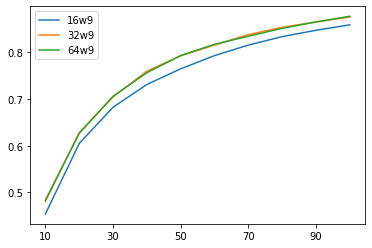

In [71]:
plot_eval(dfs_vecsize_eval,names_size_eval)

In [72]:
hitrate_score = 0.64

#### Conclusion

As a result:
- size = 64
- window_size = 9
- negetive_sampling = 20

## Overall

In [74]:
best_model = Word2Vec.load(BEST_MODEL)
score_ndcg = evaluate_with_model_ndcg(best_model)

2021-01-10 10:59:10,708 - gensim.utils - INFO - loading Word2Vec object from models_vecsize/64w9_model.model
2021-01-10 10:59:10,726 - gensim.utils - INFO - loading wv recursively from models_vecsize/64w9_model.model.wv.* with mmap=None
2021-01-10 10:59:10,727 - gensim.utils - INFO - setting ignored attribute vectors_norm to None
2021-01-10 10:59:10,728 - gensim.utils - INFO - loading vocabulary recursively from models_vecsize/64w9_model.model.vocabulary.* with mmap=None
2021-01-10 10:59:10,729 - gensim.utils - INFO - loading trainables recursively from models_vecsize/64w9_model.model.trainables.* with mmap=None
2021-01-10 10:59:10,730 - gensim.utils - INFO - setting ignored attribute cum_table to None
2021-01-10 10:59:10,730 - gensim.utils - INFO - loaded models_vecsize/64w9_model.model
2021-01-10 10:59:10,755 - gensim.models.keyedvectors - INFO - precomputing L2-norms of word weight vectors


In [75]:
pd.DataFrame({"ndcg":score_ndcg,"hit-rate":hitrate_score}, index = ['score'])

,ndcg,hit-rate
score,0.083607,0.64
